### Importing required Libraries

In [2]:
import pandas as pd
import numpy as np
import pymysql
from db_config import MYSQL_HOST, MYSQL_USER, MYSQL_PASSWORD, MYSQL_DATABASE
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from transformers import pipeline

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Database connection function (reusing from your existing code)
def connect_db():
    """Establishes a connection to the MySQL database."""
    try:
        conn = pymysql.connect(
            host=MYSQL_HOST,
            user=MYSQL_USER,
            password=MYSQL_PASSWORD,
            database=MYSQL_DATABASE,
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
        return conn
    except pymysql.MySQLError as e:
        print("❌ Database Connection Error:", e)
        return None


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Function 1: Fetch posts from database

In [3]:
def fetch_posts(days_ago=120):
    """Fetches posts from the database within the specified time period."""
    conn = connect_db()
    if not conn:
        return []
    
    try:
        cursor = conn.cursor()
        query = """
        SELECT * FROM reddit_posts 
        WHERE created_at >= DATE_SUB(NOW(), INTERVAL %s DAY)
        ORDER BY created_at DESC
        """
        cursor.execute(query, (days_ago,))
        posts = cursor.fetchall()
        print(f"📊 Fetched {len(posts)} posts from the last {days_ago} days")
        return posts
    except pymysql.MySQLError as e:
        print("❌ MySQL Error:", e)
        return []
    finally:
        cursor.close()
        conn.close()

# Function 2: Basic Sentiment Analysis with TextBlob

In [4]:

def analyze_sentiment_textblob(text):
    """Analyzes sentiment of a text using TextBlob."""
    analysis = TextBlob(text)
    
    # Determine sentiment category
    if analysis.sentiment.polarity > 0.05:
        sentiment = "positive"
    elif analysis.sentiment.polarity < -0.05:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    
    return {
        "polarity": analysis.sentiment.polarity,
        "subjectivity": analysis.sentiment.subjectivity,
        "sentiment": sentiment
    }


# Function 3: Advanced Sentiment Analysis with Hugging Face

In [5]:
def analyze_sentiment_advanced(texts, batch_size=16):
    """Analyzes sentiment using a pre-trained transformer model."""
    sentiment_analyzer = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")
    
    # Process in batches to avoid memory issues
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_results = sentiment_analyzer(batch)
        results.extend(batch_results)
    
    return results

# Function 4: Time Series Analysis

In [6]:

def analyze_post_trends(posts):
    """Analyzes posting trends over time."""
    df = pd.DataFrame(posts)
    
    # Convert created_at to datetime
    df['created_at'] = pd.to_datetime(df['created_at'])
    
    # Create date column for grouping
    df['date'] = df['created_at'].dt.date
    
    # Group by date and count posts
    daily_counts = df.groupby('date').size().reset_index(name='post_count')
    
    # Calculate daily average sentiment
    df['sentiment_score'] = df['body'].apply(lambda x: analyze_sentiment_textblob(x)['polarity'])
    daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index(name='avg_sentiment')
    
    # Merge the two dataframes
    trend_data = pd.merge(daily_counts, daily_sentiment, on='date')
    
    return trend_data

# Function 5: Common Topics/Keywords Analysis

In [7]:
def analyze_common_topics(posts, top_n=20):
    """Extracts and counts common topics/keywords from posts."""
    stop_words = set(stopwords.words('english'))
    additional_stops = {"like", "just", "feel", "feeling", "really", "i'm", "im", "don't", "dont"}
    stop_words.update(additional_stops)
    
    all_words = []
    
    for post in posts:
        # Combine title and body for full text analysis
        text = f"{post['title']} {post['body']}"
        
        # Tokenize and filter
        words = word_tokenize(text.lower())
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
        
        all_words.extend(filtered_words)
    
    # Count occurrences
    word_counts = Counter(all_words)
    
    # Get top N words
    top_words = word_counts.most_common(top_n)
    
    return top_words, word_counts

# Function 6: Generate Word Cloud

In [8]:

def generate_wordcloud(word_counts):
    """Generates a word cloud from word counts."""
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        colormap='viridis',
        contour_width=1
    ).generate_from_frequencies(dict(word_counts))
    
    return wordcloud

# Function 7: Overall Statistics

In [9]:
def get_statistics(posts):
    """Calculates overall statistics from the posts."""
    df = pd.DataFrame(posts)
    
    # Basic statistics
    total_posts = len(posts)
    avg_upvotes = df['upvotes'].mean()
    
    # Apply sentiment analysis to all posts
    sentiments = [analyze_sentiment_textblob(post['body']) for post in posts]
    sentiment_df = pd.DataFrame(sentiments)
    
    # Calculate sentiment distribution
    sentiment_counts = sentiment_df['sentiment'].value_counts()
    avg_polarity = sentiment_df['polarity'].mean()
    avg_subjectivity = sentiment_df['subjectivity'].mean()
    
    # Post length analysis
    df['body_length'] = df['body'].apply(len)
    avg_length = df['body_length'].mean()
    
    return {
        'total_posts': total_posts,
        'avg_upvotes': avg_upvotes,
        'sentiment_distribution': sentiment_counts.to_dict(),
        'avg_polarity': avg_polarity,
        'avg_subjectivity': avg_subjectivity,
        'avg_post_length': avg_length
    }


📊 Fetched 5304 posts from the last 60 days
🔍 Performing sentiment analysis...
📈 Analyzing posting trends...
🔑 Extracting common topics...

📊 OVERALL STATISTICS:
Total Posts Analyzed: 5304
Average Upvotes: 11.84
Average Post Length: 988.30 characters
Average Sentiment Polarity: 0.0045
Sentiment Distribution: {'positive': 1926, 'neutral': 1718, 'negative': 1660}

✅ Analysis complete! Visualizations saved.


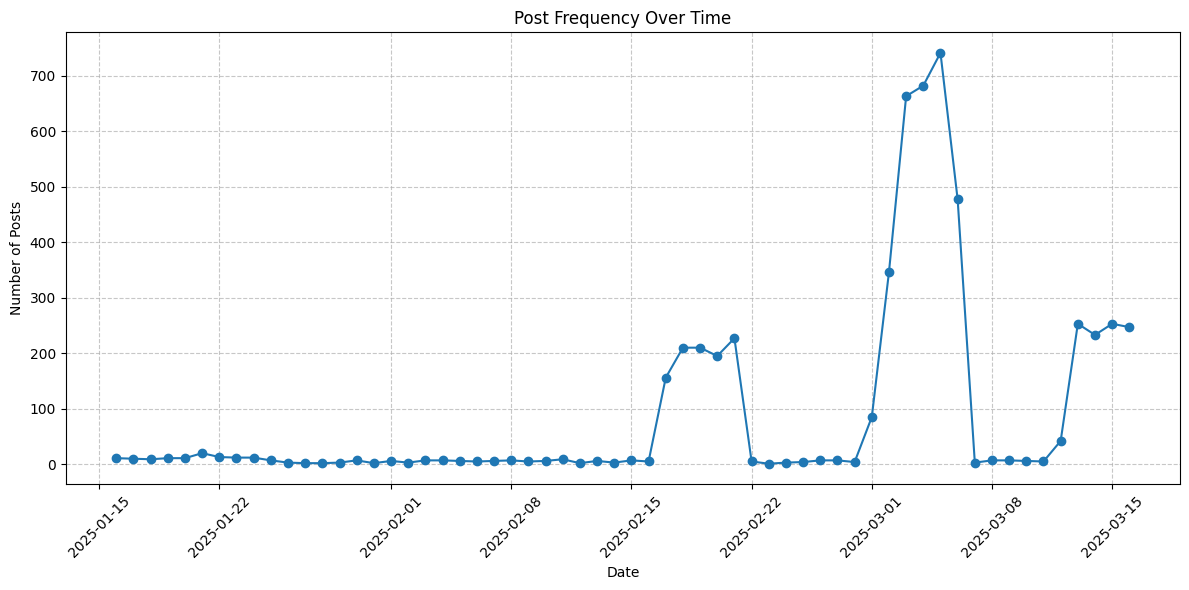

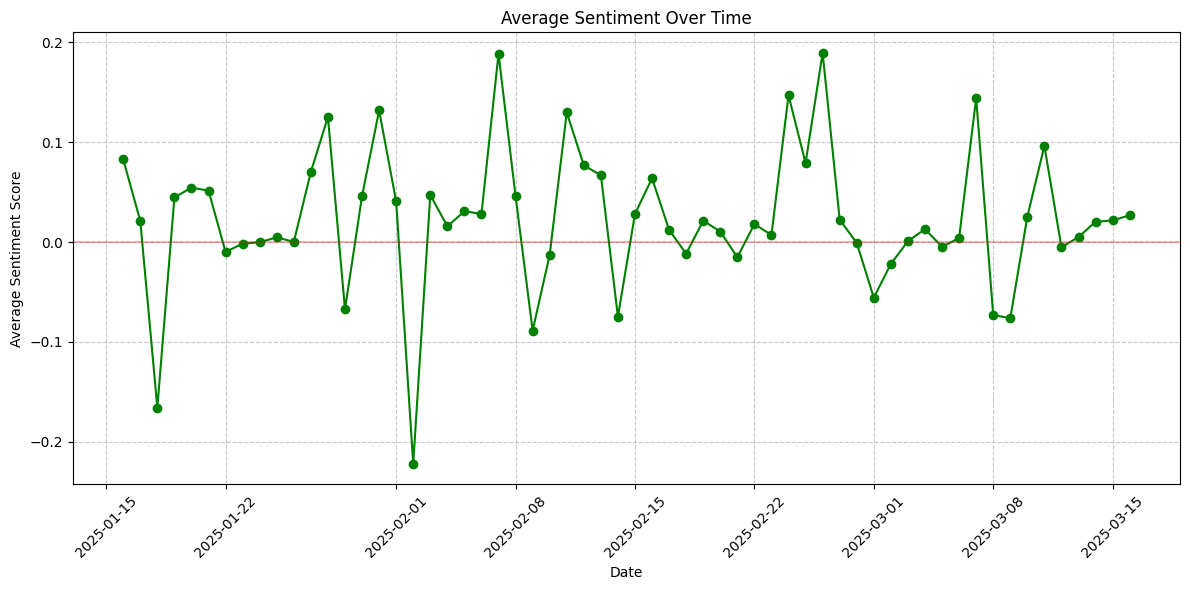

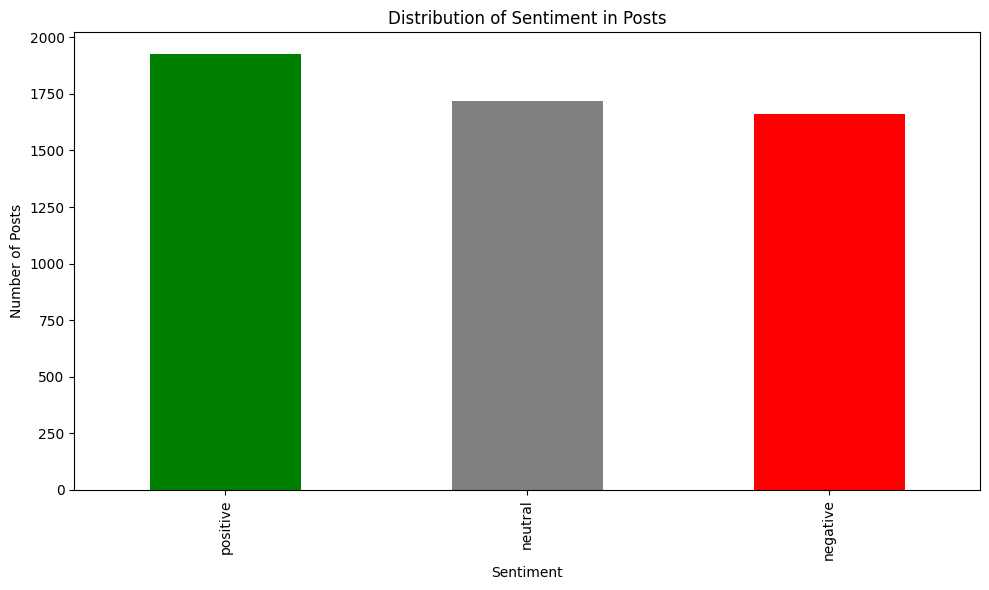

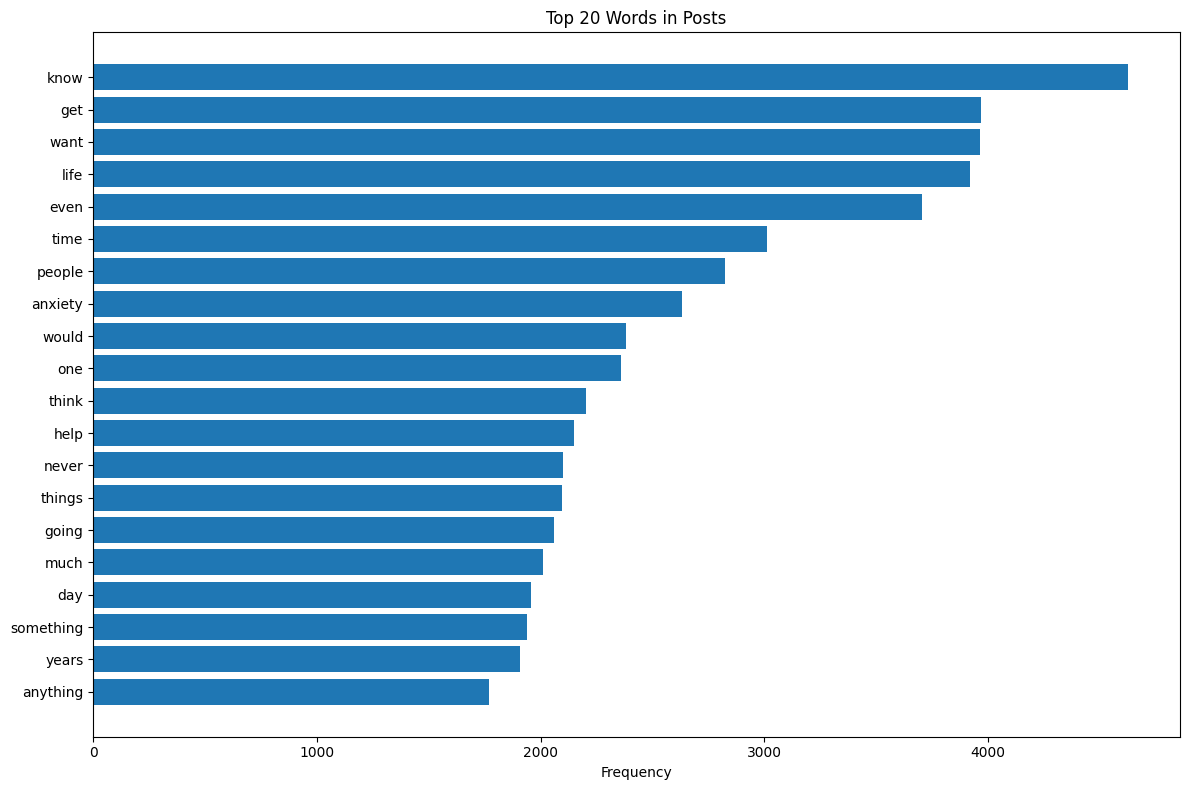

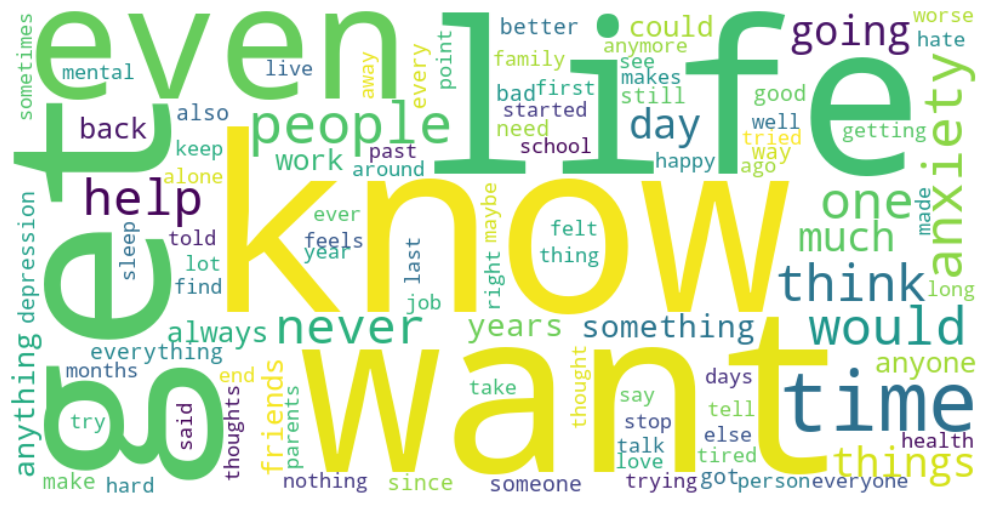

In [10]:
# Main analysis workflow
def main():
    # 1. Fetch posts from database (last 30 days)
    posts = fetch_posts(days_ago=60)
    
    if not posts:
        print("❌ No posts found for analysis")
        return
    
    # 2. Perform sentiment analysis
    print("🔍 Performing sentiment analysis...")
    df = pd.DataFrame(posts)
    df['sentiment'] = df['body'].apply(lambda x: analyze_sentiment_textblob(x)['sentiment'])
    df['polarity'] = df['body'].apply(lambda x: analyze_sentiment_textblob(x)['polarity'])
    
    # 3. Analyze trends over time
    print("📈 Analyzing posting trends...")
    trend_data = analyze_post_trends(posts)
    
    # 4. Extract common topics
    print("🔑 Extracting common topics...")
    top_words, word_counts = analyze_common_topics(posts)
    
    # 5. Generate visualization: Post frequency over time
    plt.figure(figsize=(12, 6))
    plt.plot(trend_data['date'], trend_data['post_count'], marker='o')
    plt.title('Post Frequency Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('post_frequency.png')
    
    # 6. Generate visualization: Sentiment trends over time
    plt.figure(figsize=(12, 6))
    plt.plot(trend_data['date'], trend_data['avg_sentiment'], marker='o', color='green')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Average Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('sentiment_trends.png')
    
    # 7. Generate visualization: Sentiment distribution
    plt.figure(figsize=(10, 6))
    sentiment_counts = df['sentiment'].value_counts()
    colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
    sentiment_counts.plot(kind='bar', color=[colors[x] for x in sentiment_counts.index])
    plt.title('Distribution of Sentiment in Posts')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Posts')
    plt.tight_layout()
    plt.savefig('sentiment_distribution.png')
    
    # 8. Generate visualization: Word frequency
    plt.figure(figsize=(12, 8))
    words, counts = zip(*top_words)
    plt.barh(list(reversed(words)), list(reversed(counts)))
    plt.title('Top 20 Words in Posts')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.savefig('word_frequency.png')
    
    # 9. Generate word cloud
    wordcloud = generate_wordcloud(word_counts)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('wordcloud.png')
    
    # 10. Calculate and display overall statistics
    stats = get_statistics(posts)
    print("\n📊 OVERALL STATISTICS:")
    print(f"Total Posts Analyzed: {stats['total_posts']}")
    print(f"Average Upvotes: {stats['avg_upvotes']:.2f}")
    print(f"Average Post Length: {stats['avg_post_length']:.2f} characters")
    print(f"Average Sentiment Polarity: {stats['avg_polarity']:.4f}")
    print(f"Sentiment Distribution: {stats['sentiment_distribution']}")
    
    print("\n✅ Analysis complete! Visualizations saved.")

if __name__ == "__main__":
    main()